In [1]:
import sys
import os
import random
import gc
import time
import torch
import numpy as np
import pandas as pd
import ast
from tqdm import tqdm
from scipy.stats import spearmanr, pearsonr, kendalltau, rankdata
from sklearn.metrics import ndcg_score
from transformers import AutoModelForCausalLM, AutoTokenizer
from accelerate import Accelerator
os.environ["CUDA_VISIBLE_DEVICES"] = "3" 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from SHapRAG.rag_shap import *
from SHapRAG.utils import *

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
%pip install google.oauth2

In [2]:
df= pd.read_csv("../data/synthetic_data/20_synergy_hard_negatives.csv",index_col=False, sep=";")
# df= pd.read_csv("../data/complementary.csv")

In [3]:
SEED = 42
# Initialize Accelerator
accelerator_main = Accelerator(mixed_precision="fp16")

# Load Model
if accelerator_main.is_main_process:
    print("Main Script: Loading model...")
# model_path = "mistralai/Mistral-7B-Instruct-v0.3"
model_path = "meta-llama/Llama-3.1-8B-Instruct"
# model_path = "Qwen/Qwen2.5-3B-Instruct"

model_cpu = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model_cpu.config.pad_token_id = tokenizer.pad_token_id
    if hasattr(model_cpu, 'generation_config') and model_cpu.generation_config is not None:
        model_cpu.generation_config.pad_token_id = tokenizer.pad_token_id

if accelerator_main.is_main_process:
    print("Main Script: Preparing model with Accelerator...")
prepared_model = accelerator_main.prepare(model_cpu)
unwrapped_prepared_model = accelerator_main.unwrap_model(prepared_model)
unwrapped_prepared_model.eval()
if accelerator_main.is_main_process:
    print("Main Script: Model prepared and set to eval.")

# Define utility cache

accelerator_main.wait_for_everyone()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Main Script: Loading model...


Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


Main Script: Preparing model with Accelerator...
Main Script: Model prepared and set to eval.


In [4]:
num_questions_to_run=len(df.question)
# num_questions_to_run=1
k_values = [1,2,3,4,5]
all_results=[]
extras=[]
# Define ground truth set of docs for precision (adapt as needed)
# e.g., if first 2 docs are always relevant
def get_gtset_k():
    return [0, 1]
correctness=[]
llm_response=[]
for i in tqdm(range(num_questions_to_run), disable=not accelerator_main.is_main_process):
    query = df.question[i]
    if accelerator_main.is_main_process:
        print(f"\n--- Question {i+1}/{num_questions_to_run}: {query[:60]}... ---")

    p = ast.literal_eval(df.context[i])
    docs = p[:5] + [p[1]] + p[5:]
    utility_cache_base_dir = f"../Experiment_data/synthetic/{model_path.split('/')[1]}/duplicates"
    utility_cache_filename = f"utilities_q_idx{i}.pkl"
    current_utility_path = os.path.join(utility_cache_base_dir, utility_cache_filename)

    if accelerator_main.is_main_process:
        os.makedirs(os.path.dirname(current_utility_path), exist_ok=True)

    harness = ContextAttribution(
        items=docs,
        query=query,
        prepared_model=prepared_model,
        prepared_tokenizer=tokenizer,
        accelerator=accelerator_main,
        utility_cache_path=current_utility_path
    )
    res = evaluate(df.question[i], harness.target_response, df.answer[i])
    correctness.append(res)
    llm_response.append(harness.target_response)
    if res=="True":

        if accelerator_main.is_main_process:
            methods_results = {}
            metrics_results = {}
            extra_results = {}

            m_samples_map = {"L": 364}

            # Store FM models for later R²/MSE
            fm_models = {}

            for size_key, num_s in m_samples_map.items():
                if 2 ** len(docs) < num_s and size_key != "L":
                    actual_samples = max(1, 2 ** len(docs) - 1 if 2 ** len(docs) > 0 else 1)
                else:
                    actual_samples = num_s

                if actual_samples > 0:
                    methods_results[f"ContextCite{actual_samples}"], model_cc = harness.compute_contextcite(
                        num_samples=actual_samples, seed=SEED
                    )

                    attributions, interactions= harness.compute_spex(sample_budget=actual_samples, max_order=2)
                    methods_results[f"FBII{actual_samples}"] = attributions['fbii']
                    methods_results[f"Spex{actual_samples}"] = attributions['fourier']
                    methods_results[f"FSII{actual_samples}"] = attributions['fsii']

                    # methods_results[f"FM_WeightsDU{actual_samples}"], Fdu, modelfmdu = harness.compute_wss(
                    #     num_samples=actual_samples, seed=SEED, sampling="uniform",
                    #     sur_type="fm", utility_mode="divergence_utility"
                    # )
                    # methods_results[f"FM_WeightsDK{actual_samples}"], Fdk, modelfmdk = harness.compute_wss(
                    #     num_samples=actual_samples, seed=SEED, sampling="kernelshap",
                    #     sur_type="fm", utility_mode="divergence_utility"
                    # )
                    # methods_results[f"FM_WeightsLK{actual_samples}"], Flk, modelfmlk = harness.compute_wss(
                    #     num_samples=actual_samples, seed=SEED, sampling="kernelshap", sur_type="fm"
                    # )
                    methods_results[f"FM_WeightsLU{actual_samples}"], Flu, modelfmlu = harness.compute_wss(
                        num_samples=actual_samples, seed=SEED, sampling="uniform", sur_type="fm"
                    )

                    # Save FM models
                    fm_models.update({
                        # f"FM_WeightsDU{actual_samples}": modelfmdu,
                        # f"FM_WeightsDK{actual_samples}": modelfmdk,
                        # f"FM_WeightsLK{actual_samples}": modelfmlk,
                        f"FM_WeightsLU{actual_samples}": modelfmlu
                    })

                    # Save extra Fs
                    extra_results.update({
                        # "Fdu": Fdu,
                        # "Fdk": Fdk,
                        # "Flk": Flk,
                        "Flu": Flu,
                        "Int_FSII":interactions['fsii'],
                        "Int_FBII":interactions['fbii'],
                        "Int_Spex":interactions['fourier']
                    })

            methods_results["LOO"] = harness.compute_loo()
            methods_results["ARC-JSD"] = harness.compute_arc_jsd()

            # --- Evaluation Metrics ---
            metrics_results["topk_probability"] = harness.evaluate_topk_performance(
                methods_results, k_values, utility_type="probability", model=modelfmlu
            )
            metrics_results["topk_divergence"] = harness.evaluate_topk_performance(
                methods_results, k_values, utility_type="divergence", model=modelfmlu
            )
            metrics_results["topk_response_probability"] = harness.top_k_response_probability(
                methods_results, k_values=[1, 2,3]
            )

            # R² and MSE for ContextCite
            r2, mse = harness.r2_mse(30, 'logit-prob', model_cc, method='cc')
            metrics_results["R2_cc"] = r2
            metrics_results["MSE_cc"] = mse

            # R² and MSE for each FM method that has a model
            for method_name, fm_model in fm_models.items():
                r2, mse = harness.r2_mse(30, 'logit-prob', fm_model, method='fm')
                metrics_results[f"R2_{method_name}"] = r2
                metrics_results[f"MSE_{method_name}"] = mse

            # LDS per method
            LDS = {}
            for method_name, scores in methods_results.items():
                if "FM_WeightsLU" in method_name:
                    LDS[method_name] = harness.lds(scores, 30, utl=True, model=modelfmlu)
                else:
                    LDS[method_name] = harness.lds(scores, 30)
            metrics_results["LDS"] = LDS

            # Precision per method
            precision_scores = {}
            gtset_k = get_gtset_k()
            for method_name, scores in methods_results.items():
                precision_scores[method_name] = harness.precision(gtset_k, scores)
            metrics_results["precision"] = precision_scores

            harness.save_utility_cache(current_utility_path)

            all_results.append({
                "query_index": i,
                "query": query,
                "ground_truth": df.answer[i],
                "response": harness.target_response,
                "methods": methods_results,
                "metrics": metrics_results
            })
            extras.append(extra_results)
df['correctness']=correctness
df['llm_response']=llm_response

  0%|          | 0/20 [00:00<?, ?it/s]


--- Question 1/20: What kind of energy does the facility hovering the planet Xy... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx0.pkl...
Successfully loaded 1345 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 248328.99it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  5%|▌         | 1/20 [00:25<08:04, 25.51s/it]

Main Process: Saving 1345 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx0.pkl...
Save complete.

--- Question 2/20: What is the primary defense of the creatures populating the ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx1.pkl...
Successfully loaded 1350 cached utility entries.


 10%|█         | 2/20 [00:27<03:26, 11.46s/it]


--- Question 3/20: What is the main function of the device recently discovered ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx2.pkl...
Successfully loaded 1346 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 224057.33it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 15%|█▌        | 3/20 [00:36<03:00, 10.60s/it]

Main Process: Saving 1346 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx2.pkl...
Save complete.

--- Question 4/20: What is the composition of the natural wonder of planet Ntun... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx3.pkl...
Successfully loaded 1345 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 238812.24it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 20%|██        | 4/20 [00:47<02:49, 10.61s/it]

Main Process: Saving 1345 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx3.pkl...
Save complete.

--- Question 5/20: What is the traditional weapon of the defenders of the Citad... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx4.pkl...
Successfully loaded 1348 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 238402.04it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 25%|██▌       | 5/20 [00:57<02:36, 10.46s/it]

Main Process: Saving 1348 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx4.pkl...
Save complete.

--- Question 6/20: What kind of power source is used by the ancient constructs ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx5.pkl...
Successfully loaded 1347 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 230902.40it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 30%|███       | 6/20 [01:07<02:24, 10.29s/it]

Main Process: Saving 1347 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx5.pkl...
Save complete.

--- Question 7/20: What is the primary ingredient of the most famous healing po... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx6.pkl...
Successfully loaded 1343 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 201123.26it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 35%|███▌      | 7/20 [01:17<02:13, 10.29s/it]

Main Process: Saving 1343 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx6.pkl...
Save complete.

--- Question 8/20: What defensive ability is possessed by the strongest creatur... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx7.pkl...
Successfully loaded 1346 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 245889.30it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 40%|████      | 8/20 [01:28<02:04, 10.37s/it]

Main Process: Saving 1346 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx7.pkl...
Save complete.

--- Question 9/20: What is the energy source of the massive orbital platform or... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx8.pkl...
Successfully loaded 1349 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 237919.07it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 45%|████▌     | 9/20 [01:38<01:52, 10.22s/it]

Main Process: Saving 1349 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx8.pkl...
Save complete.

--- Question 10/20: What is the population of the capital of the biggest country... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx9.pkl...
Successfully loaded 1348 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 201548.07it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 50%|█████     | 10/20 [01:48<01:41, 10.16s/it]

Main Process: Saving 1348 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx9.pkl...
Save complete.

--- Question 11/20: What's the weather like in the capital of Zhykara?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx10.pkl...
Successfully loaded 1347 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 210699.23it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 55%|█████▌    | 11/20 [01:58<01:31, 10.14s/it]

Main Process: Saving 1347 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx10.pkl...
Save complete.

--- Question 12/20: What's the value of the element obtained by mixing Aethelite... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx11.pkl...
Successfully loaded 1349 cached utility entries.


 60%|██████    | 12/20 [01:59<00:58,  7.36s/it]


--- Question 13/20: What's the side effect of mixing Gravitium and Solara?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx12.pkl...
Successfully loaded 1351 cached utility entries.


 65%|██████▌   | 13/20 [02:00<00:37,  5.37s/it]


--- Question 14/20: What is the radius of the largest planet in the K'tharr Syst... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx13.pkl...
Successfully loaded 1346 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 238886.97it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 70%|███████   | 14/20 [02:10<00:41,  6.90s/it]

Main Process: Saving 1346 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx13.pkl...
Save complete.

--- Question 15/20: What is the population of the smallest planet in the Lumina ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx14.pkl...
Successfully loaded 1346 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 239261.35it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 75%|███████▌  | 15/20 [02:21<00:40,  8.07s/it]

Main Process: Saving 1346 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx14.pkl...
Save complete.

--- Question 16/20: What is the title of the latest film starring the highest-pa... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx15.pkl...
Successfully loaded 1346 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 231042.17it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 80%|████████  | 16/20 [02:31<00:35,  8.81s/it]

Main Process: Saving 1346 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx15.pkl...
Save complete.

--- Question 17/20: What is the salary of the most popular actor on the planet A... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx16.pkl...
Successfully loaded 1346 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 235388.01it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 85%|████████▌ | 17/20 [02:42<00:27,  9.33s/it]

Main Process: Saving 1346 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx16.pkl...
Save complete.

--- Question 18/20: What is the title of the first album by the most popular Chr... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx17.pkl...
Successfully loaded 1344 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 231112.12it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 90%|█████████ | 18/20 [02:52<00:19,  9.55s/it]

Main Process: Saving 1344 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx17.pkl...
Save complete.

--- Question 19/20: What is the total number of plays for the most critically ap... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx18.pkl...
Successfully loaded 1349 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 229790.29it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 95%|█████████▌| 19/20 [03:02<00:09,  9.83s/it]

Main Process: Saving 1349 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx18.pkl...
Save complete.

--- Question 20/20: What is the effect of drinking water from the sacred spring ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx19.pkl...
Successfully loaded 1343 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 198250.44it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 20/20 [03:13<00:00,  9.69s/it]

Main Process: Saving 1343 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx19.pkl...
Save complete.


In [18]:
df

,question,context,answer,doc_id,correctness,llm_response
0,What kind of energy does the facility hovering...,"[""The 'Stellar Converter' is a massive energy ...",The 'Stellar Converter' on the planet Xylos pr...,"[""A"", ""B"", ""C"", ""D"", ""E"", ""F"", ""G"", ""H"", ""I"", ...",True,Electrical power.
1,What is the primary defense of the creatures p...,"[""The 'Subterranean Caves' are a network of de...",The primary defense of the Glow-worms in the S...,"[""A"", ""B"", ""C"", ""D"", ""E"", ""F"", ""G"", ""H"", ""I"", ...",False,The primary defense of the creatures populatin...
2,What is the main function of the device recent...,"[""The 'Chrono-Regulator' is a complex piece of...",The main function of the 'Chrono-Regulator' is...,"[""A"", ""B"", ""C"", ""D"", ""E"", ""F"", ""G"", ""H"", ""I"", ...",True,Stabilize localized temporal distortions.
3,What is the composition of the natural wonder ...,"[""The 'Floating Islands of Aeridia' are the mo...",The 'Floating Islands of Aeridia' are primaril...,"[""A"", ""B"", ""C"", ""D"", ""E"", ""F"", ""G"", ""H"", ""I"", ...",True,The 'Floating Islands of Aeridia' are primaril...
4,What is the traditional weapon of the defender...,"[""The 'Sky-Guardians' are the elite protectors...",The traditional weapon of the Sky-Guardians of...,"[""A"", ""B"", ""C"", ""D"", ""E"", ""F"", ""G"", ""H"", ""I"", ...",True,A ceremonial blade forged from Storm-Metal.
5,What kind of power source is used by the ancie...,"[""In the desolate 'Desert of Bones', ancient W...",The ancient War Golems found in the Desert of ...,"[""A"", ""B"", ""C"", ""D"", ""E"", ""F"", ""G"", ""H"", ""I"", ...",True,"Animus Cores, Geothermal Converters, and Starl..."
6,What is the primary ingredient of the most fam...,"[""'Sunpetal Balm' is the most famous potion kn...",The primary ingredient of the healing potion k...,"[""A"", ""B"", ""C"", ""D"", ""E"", ""F"", ""G"", ""H"", ""I"", ...",True,Finely ground powder from Glow-Moss.
7,What defensive ability is possessed by the str...,"[""The 'Bioluminescent Forest' is a vibrant eco...",The creature known as the 'Thorned Crawler' in...,"[""A"", ""B"", ""C"", ""D"", ""E"", ""F"", ""G"", ""H"", ""I"", ...",True,Instantaneous growth of razor-sharp crystallin...
8,What is the energy source of the massive orbit...,"[""The 'Aegis Station' is a huge orbital platfo...",The massive orbital platform known as the 'Aeg...,"[""A"", ""B"", ""C"", ""D"", ""E"", ""F"", ""G"", ""H"", ""I"", ...",True,"A captured and contained miniature black hole,..."
9,What is the population of the capital of the b...,"[""The biggest country in Xylos-7 is Eldoria, m...",The population of the capital of Eldoria is 30...,"[""A"", ""B"", ""C"", ""D"", ""E"", ""F"", ""G"", ""H"", ""I"", ...",True,Over 300 million people.


In [7]:
import pandas as pd
import numpy as np
from collections import defaultdict

def summarize_and_print(all_results, k_values=[1, 2, 3]):
    table_data = defaultdict(lambda: defaultdict(list))

    # Mapping for consistency
    method_name_map = {
        "cc": "ContextCite364"
    }

    for res in all_results:
        metrics = res["metrics"]

        # R² / MSE
        for key, val in metrics.items():
            if key.startswith("R2_") or key.startswith("MSE_"):
                raw_method = key.split("_", 1)[1]
                method = method_name_map.get(raw_method, raw_method)  # rename if needed
                metric_name = key.split("_", 1)[0]  # "R2" or "MSE"
                table_data[method][metric_name].append(val)

        # LDS
        for method_name, lds_val in metrics["LDS"].items():
            method = method_name_map.get(method_name, method_name)
            table_data[method]["LDS"].append(lds_val)

        # Precision
        for method_name, prec_val in metrics["precision"].items():
            method = method_name_map.get(method_name, method_name)
            table_data[method]["precision"].append(prec_val)

        # Top-k
        for metric_type in ["topk_probability", "topk_divergence", "topk_response_probability"]:
            for method_name, k_dict in metrics[metric_type].items():
                method = method_name_map.get(method_name, method_name)
                for k in k_values:
                    if k in k_dict:
                        col_name = f"{metric_type}_k{k}"
                        table_data[method][col_name].append(k_dict[k])

    # Averages
    avg_table = {
        method: {metric: np.nanmean(values) for metric, values in metric_dict.items()}
        for method, metric_dict in table_data.items()
    }

    df_summary = pd.DataFrame.from_dict(avg_table, orient="index").sort_index()

    print("\n=== Metrics Summary Across All Queries ===")
    print(df_summary.to_string(float_format="%.4f"))

    return df_summary


In [8]:
df_res=summarize_and_print(all_results, k_values=[1, 2,3])


=== Metrics Summary Across All Queries ===
                    R2     MSE    LDS  precision  topk_probability_k1  topk_probability_k2  topk_probability_k3  topk_divergence_k1  topk_divergence_k2  topk_divergence_k3  topk_response_probability_k1  topk_response_probability_k2  topk_response_probability_k3
ARC-JSD            NaN     NaN 0.6234     0.7059               5.9561              13.6972              17.3430              0.7315              1.4961              1.8320                        0.0650                        0.2725                        0.2641
ContextCite364  0.5131 14.9567 0.6223     0.6176               3.5622              18.9528              23.4203              0.4649              1.8489              2.4364                        0.1615                        0.2895                        0.3915
FBII364            NaN     NaN 0.3985     0.4706               2.2315              22.3033              27.4880              0.2248              2.2301              2.737

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def compute_recall_at_k(all_results, k_values=[1,2, 3,4, 5]):
    methods = list(all_results[0]["methods"].keys())
    recall_table = {m: [] for m in methods}

    for k in k_values:
        for method in methods:
            recalls = []
            for res in all_results:
                gt_indices = set([0,1,5])  # must exist in each result
                scores = np.array(res["methods"][method])
                topk_indices = set(scores.argsort()[-k:])
                hits = len(gt_indices & topk_indices)
                recalls.append(hits / len(gt_indices) if gt_indices else np.nan)
            recall_table[method].append(np.nanmean(recalls))
    return recall_table


def plot_recall_at_k(recall_table, k_values=[1,2, 3,4, 5]):
    plt.figure(figsize=(8, 5))
    for method, recalls in recall_table.items():
        plt.plot(k_values, recalls, marker="o", label=method)
    plt.xlabel("k")
    plt.ylabel("Recall@k")
    plt.title("Recall@k for All Methods")
    plt.xticks(k_values)
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()


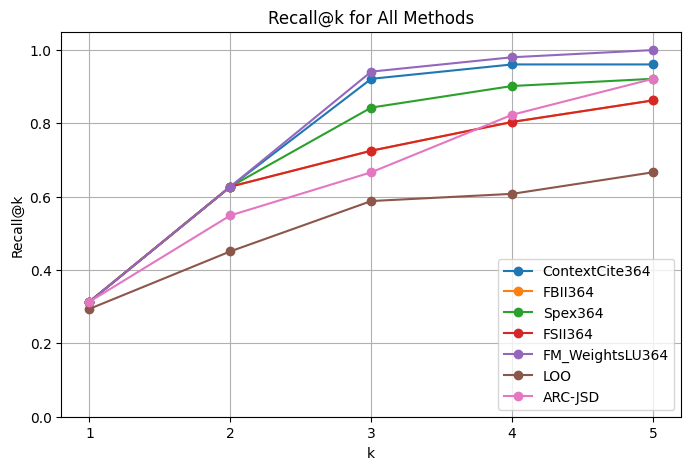

In [10]:
recall_table=compute_recall_at_k(all_results, k_values=[1, 2, 3, 4, 5])
plot_recall_at_k(recall_table, k_values=[1, 2, 3, 4, 5])

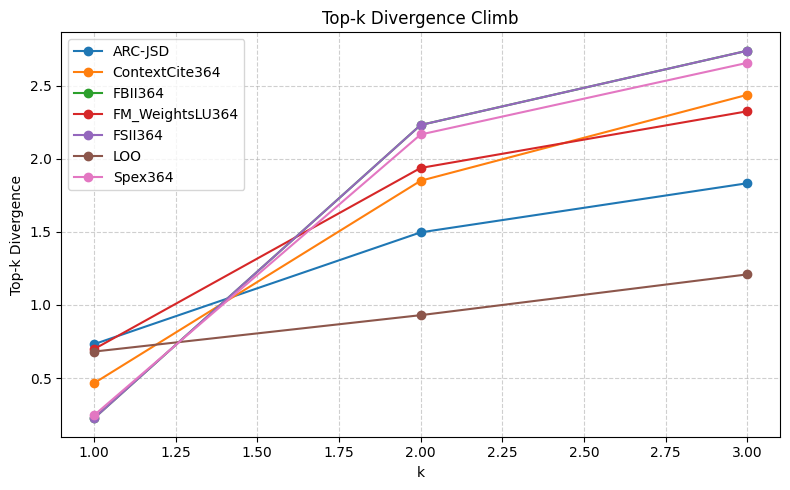

In [22]:
plt.figure(figsize=(8, 5))
for method in df_res.index:
    plt.plot(
        [1, 2, 3],
        df_res.loc[method, ['topk_divergence_k1', 'topk_divergence_k2', 'topk_divergence_k3']],
        marker='o',
        label=method
    )

plt.xlabel('k')
plt.ylabel('Top-k Divergence')
plt.title('Top-k Divergence Climb')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
all_results

In [11]:
import numpy as np

def evaluate_methods(extras, k, m, interaction_type="max"):

    methods = ["Flu", "Int_FSII", "Int_FBII", "Int_Spex"]
    scores = {m: 0 for m in methods}
    n_experiments = len(extras)

    for exp in extras:
        for method in methods:
            if method == "Flu":
                # Flu is a matrix
                value = exp["Flu"][k][m]
                all_values = exp["Flu"].flatten()
            else:
                # Dictionaries with tuple keys
                d = exp[method]
                value = None
                for key, v in d.items():
                    ones = [i for i, bit in enumerate(key) if bit == 1]
                    if set(ones) == {k, m}:
                        value = v
                        break
                if value is None:
                    continue  # skip if (k,m) not found
                all_values = list(d.values())

            if interaction_type == "max":
                if value == max(all_values):
                    scores[method] += 1
            elif interaction_type == "min":
                if value == min(all_values):
                    scores[method] += 1

    # Convert to fraction of experiments
    results = {method: scores[method] / n_experiments for method in methods}
    return results

In [17]:
evaluate_methods(extras, k=1, m=0, interaction_type="max")

{'Flu': 0.29411764705882354,
 'Int_FSII': 0.23529411764705882,
 'Int_FBII': 0.23529411764705882,
 'Int_Spex': 0.23529411764705882}

In [ ]:
[i['Flu'][0].argmax() for i in extras]

In [ ]:
all_results[12]

In [ ]:
ast.literal_eval(df.context[3])